In [1]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend('ibm_brisbane')
target = backend.target
basis_gates = list(target.operation_names)
print(basis_gates)

['id', 'rz', 'sx', 'x', 'ecr', 'reset', 'measure', 'for_loop', 'switch_case', 'if_else', 'delay']


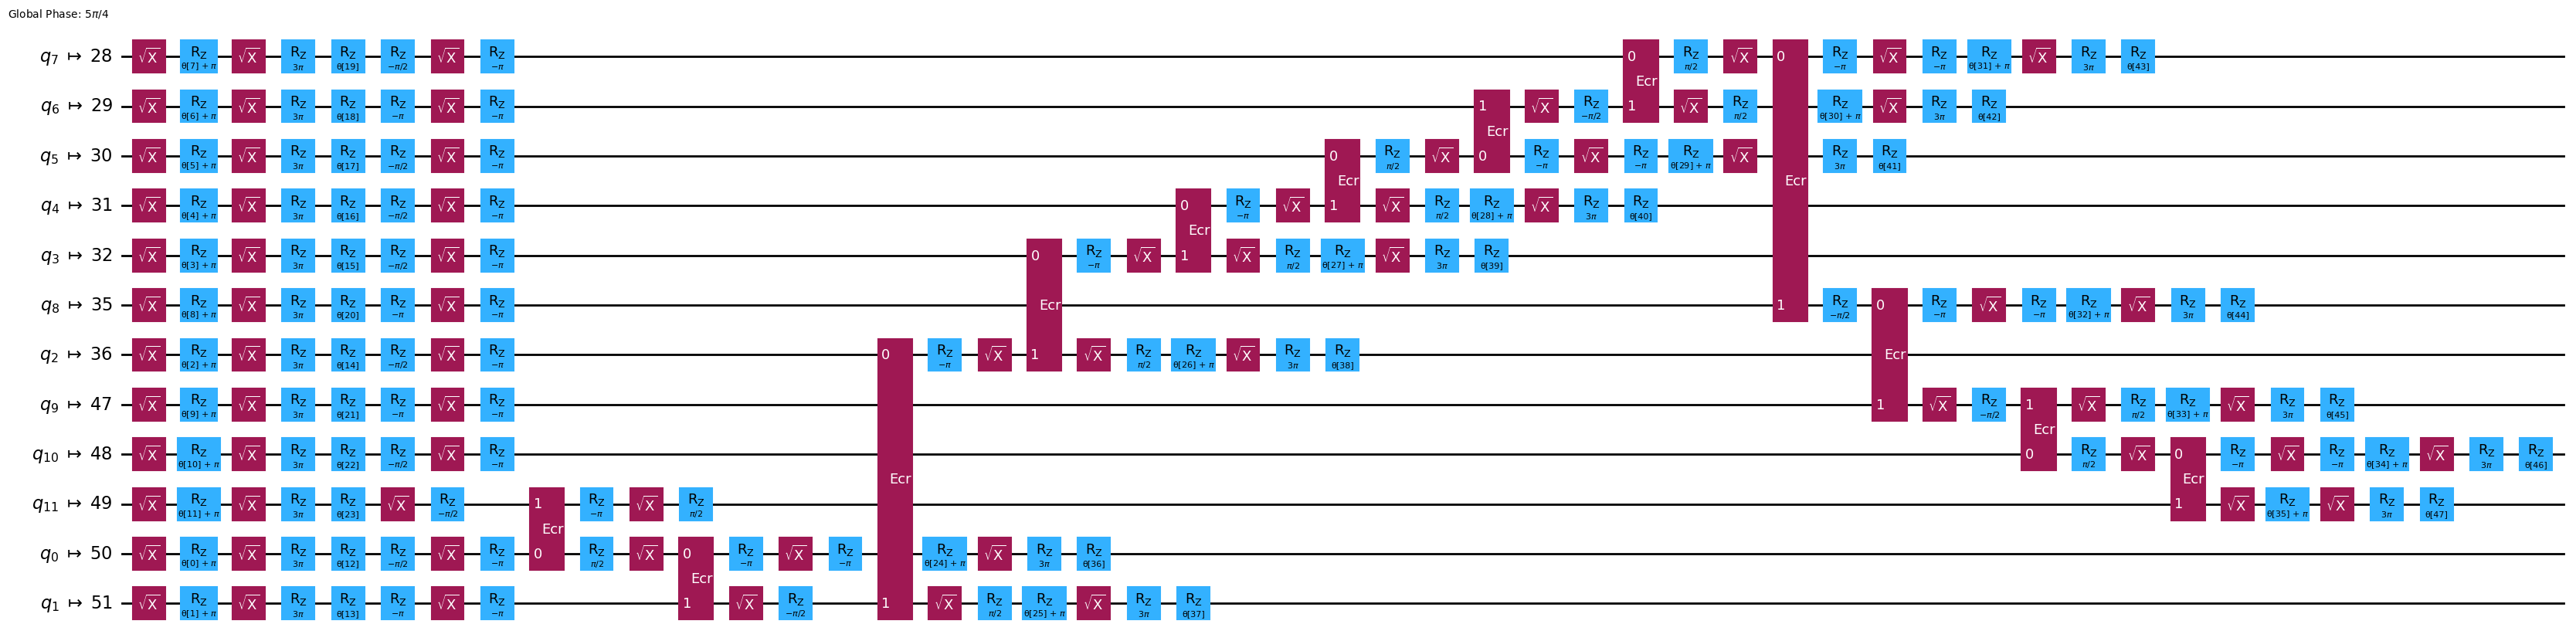

In [2]:
from qiskit.circuit.library import EfficientSU2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

qc = EfficientSU2(12, entanglement = 'circular', reps = 1)
pm = generate_preset_pass_manager(1, target=target, seed_transpiler=12345)
qc_t = pm.run(qc)
qc_t.draw('mpl', fold = -1, idle_wires=False)

In [3]:
from qiskit.circuit.library import XGate, YGate

X = XGate()
Y = YGate() 

dynamic_decoupling_sequence = [X, Y, X, Y]

In [4]:
from qiskit.transpiler import InstructionProperties

y_gate_properties = {}

for qubit in range(target.num_qubits): 
    y_gate_properties.update( 
        {
            (qubit,) : InstructionProperties(
                duration = target['x'][(qubit,)].duration,
                error = target['x'][(qubit,)].error
            )
        }
    )

target.add_instruction(YGate(), y_gate_properties)

In [5]:
import numpy as np 

rng = np.random.default_rng(1234)
qc_t.assign_parameters(rng.uniform(-np.pi, np.pi, qc_t.num_parameters), inplace=True)

In [11]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)

dd_pm = PassManager(
    [
        ALAPScheduleAnalysis(target = target), 
        PadDynamicalDecoupling(target = target, dd_sequence=dynamic_decoupling_sequence)
    ]
)

qc_dd = dd_pm.run(qc_t)

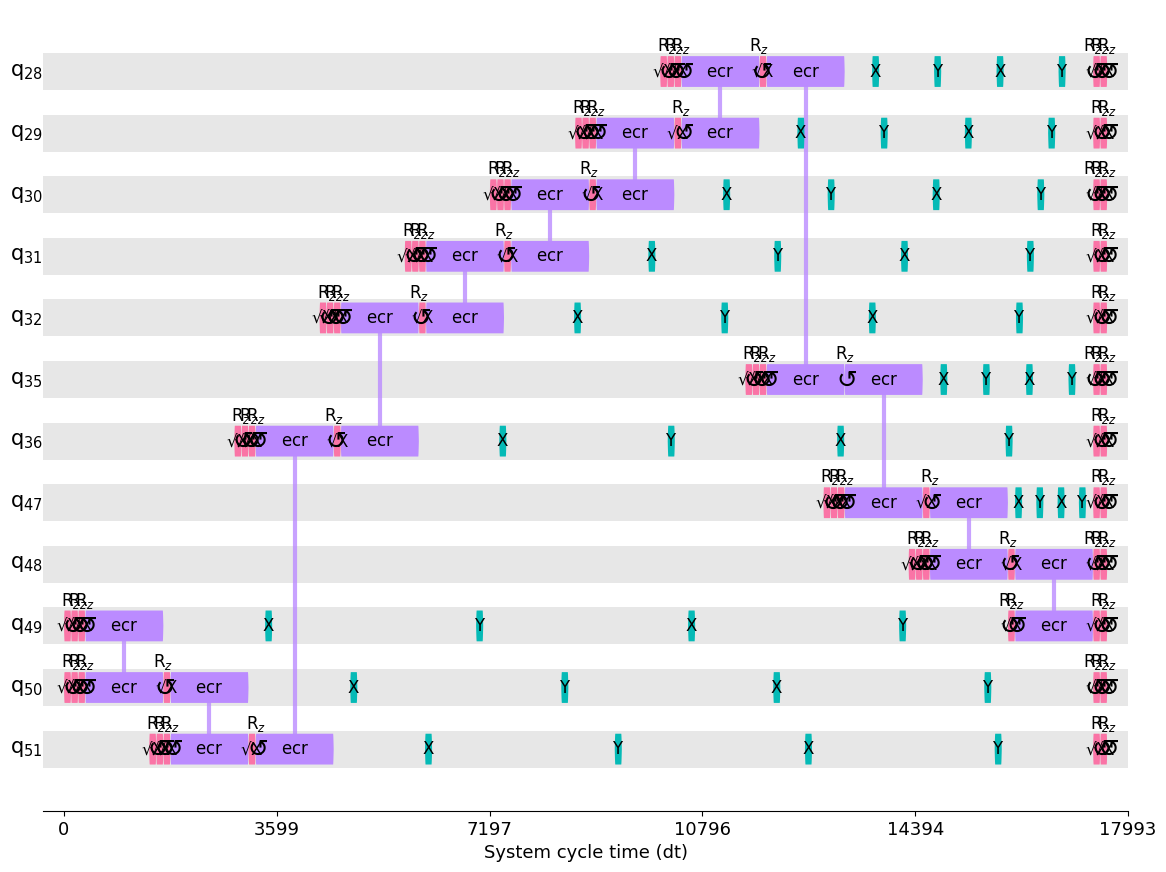

In [12]:
from qiskit.visualization import timeline_drawer

timeline_drawer(qc_dd, show_idle = False)

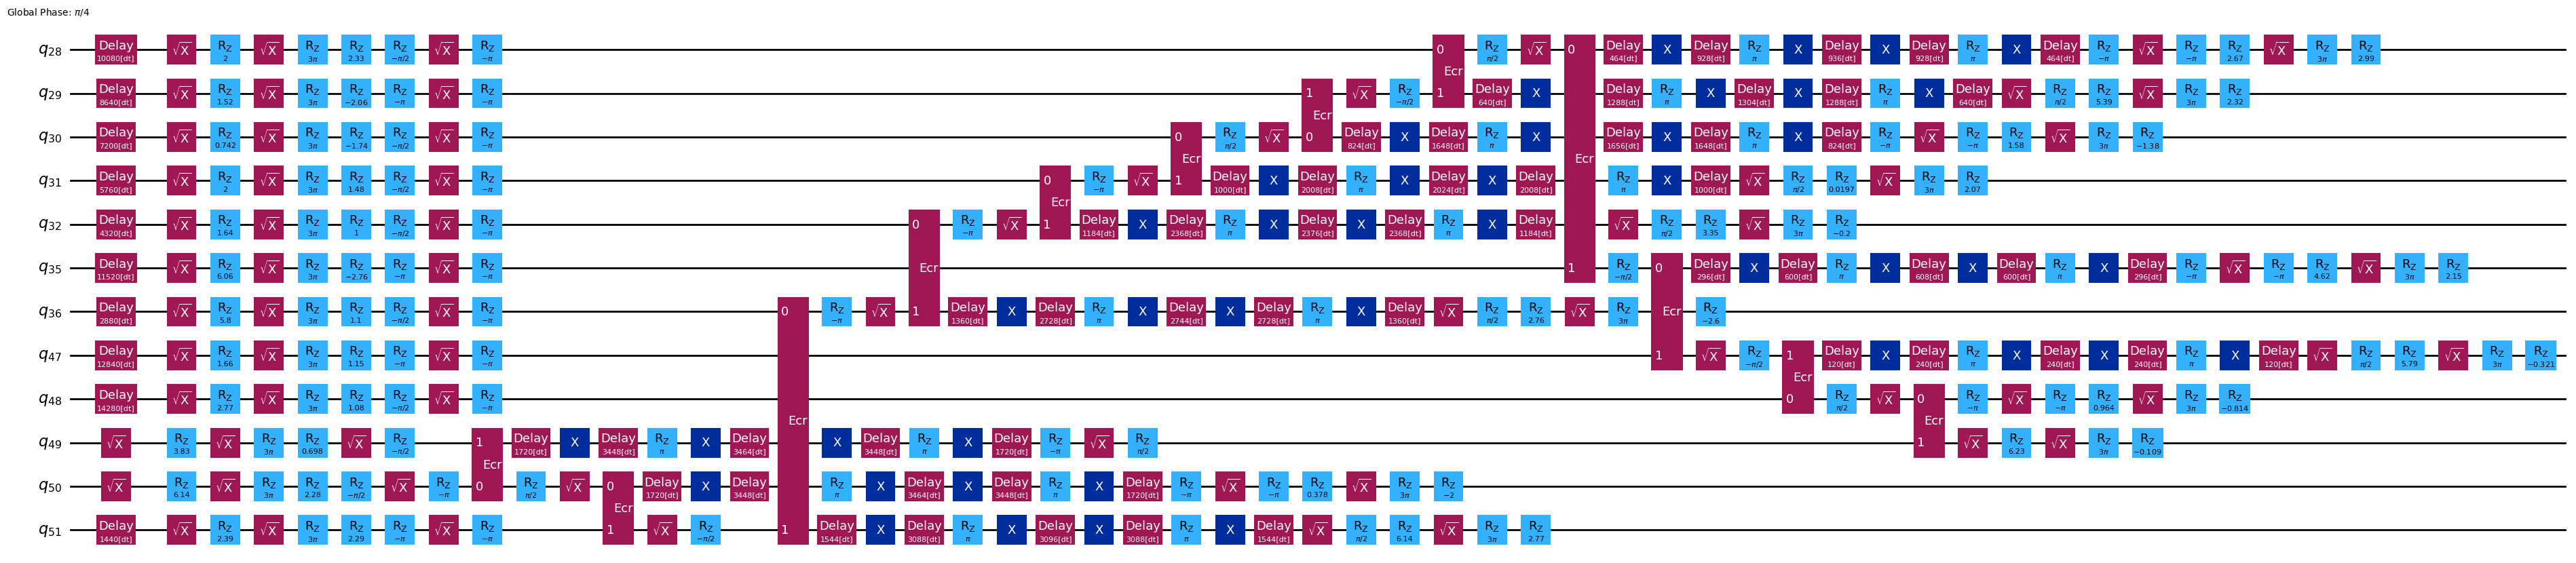

In [13]:
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary as sel
from qiskit.transpiler.passes import BasisTranslator
 
qc_dd = BasisTranslator(sel, basis_gates)(qc_dd)
qc_dd.draw("mpl", fold=-1, idle_wires=False)

In [2]:
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import XGate, YGate